# Feature Engineering for BCI

## Libraries used

In [51]:
%matplotlib inline

!pip install scipy &> /dev/null
from scipy.io import loadmat
from scipy import stats
from scipy import signal

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

!pip install tabulate &> /dev/null
from tabulate import tabulate

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

!pip install neurokit &> /dev/null
from neurokit.signal import complexity

!pip install tqdm &> /dev/null
from tqdm import tqdm

# Data

In [52]:
def extract_train_data(raw):
    train_data = {}
    train_data['signal'] = raw['Signal']
    train_data['flashing'] = raw['Flashing']
    train_data['target'] = np.array([i for i in raw['TargetChar'][0]])
    train_data['stimulus_code'] = raw['StimulusCode']
    train_data['stimulus_type'] = raw['StimulusType']
    return train_data


def extract_test_data(raw):
    test_data = {}
    test_data['signal'] = raw['Signal']
    test_data['flashing'] = raw['Flashing']
    test_data['stimulus_code'] = raw['StimulusCode']

    return test_data

## Subject A

In [53]:
compressed_raw_train_a = np.load('datasets/train_A.npz', allow_pickle = True)
raw_train_a = compressed_raw_train_a.f.arr_0.reshape([1,1])[0,0]

train_data_a = extract_train_data(raw_train_a)
del compressed_raw_train_a, raw_train_a

In [54]:
compressed_raw_test_a = np.load('datasets/test_A.npz', allow_pickle = True)
raw_test_a = compressed_raw_test_a.f.arr_0.reshape([1,1])[0,0]

test_data_a = extract_test_data(raw_test_a)

with open('datasets/true_labels_test_a.txt','r') as target:
    test_data_a['target'] = np.array(list(target.read()[:-1]))

del compressed_raw_test_a, raw_test_a

## Subject B

In [55]:
compressed_raw_train_b = np.load('datasets/train_B.npz', allow_pickle = True)
raw_train_b = compressed_raw_train_b.f.arr_0.reshape([1,1])[0,0]

train_data_b = extract_train_data(raw_train_b)
del compressed_raw_train_b, raw_train_b

In [56]:
compressed_raw_test_b = np.load('datasets/test_B.npz', allow_pickle = True)
raw_test_b = compressed_raw_test_b.f.arr_0.reshape([1,1])[0,0]

test_data_b = extract_test_data(raw_test_b)

with open('datasets/true_labels_test_b.txt','r') as target:
    test_data_b['target'] = np.array(list(target.read()[:-1]))

del compressed_raw_test_b, raw_test_b

## Constants

In [57]:
fs = 240  # Sampling frequency

n_intensification_samples = 24  # No of intensification samples during an intensification window
n_intensification_blank_samples = 18  # No of blank samples during an intensification window
n_window_samples = 42  # No of samples per intensification window 24+18
n_windows = 180  # No of intensification windows each character epoch
n_last_blank = 234  # No of blank samples when intensifications are finished

## Char Table Mapping

In [58]:
char_matrix = [ ['A', 'B', 'C', 'D', 'E', 'F'],
                ['G', 'H', 'I', 'J', 'K', 'L'],
                ['M', 'N', 'O', 'P', 'Q', 'R'],
                ['S', 'T', 'U', 'V', 'W', 'X'],
                ['Y', 'Z', '1', '2', '3', '4'],
                ['5', '6', '7', '8', '9', '_'] ]

In [59]:
def query_row_column(char):
    for i in range(len(char_matrix)):
        for j in range(len(char_matrix[i])):
            if char_matrix[i][j] == char:
                return i + 7, j + 1


def query_char(row, col):
    '''
    Col from 1 to 6
    Row from 7 to 12
    '''
    return char_matrix[row - 7][col - 1]

In [60]:
assert query_row_column('W') == (10, 5)  #row,col
assert query_char(10, 5) == 'W'

# Data Visualization

## Flashing Proof

Text(0.5, 1.0, 'Ending Interval')

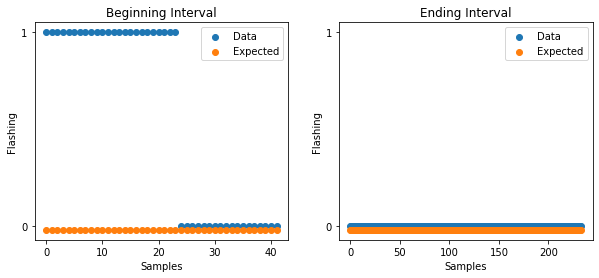

In [61]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(range(42),train_data_a['flashing'][0,:42], label='Data')
plt.scatter(range(42),np.zeros((42)) - 0.02, label='Expected')
plt.xlabel('Samples')
plt.ylabel('Flashing')
plt.legend()
plt.yticks([0,1])
plt.title('Beginning Interval')
bottom,top = plt.ylim()
plt.subplot(1,2,2)
plt.scatter(range(234),train_data_a['flashing'][0,-234:], label='Data')
plt.scatter(range(234),np.zeros((234)) - 0.02, label='Expected')
plt.xlabel('Samples')
plt.ylabel('Flashing')
plt.legend()
plt.yticks([0,1])
plt.ylim(bottom,top)
plt.title('Ending Interval')

## Average Data per Character

In [62]:
responses = np.zeros((12,15,240,64))
target = np.zeros((85,240,64))
nonTarget = np.zeros((85,240,64))

for char_epoch in range(train_data_a['signal'].shape[0]):

    rowcolcnt = np.zeros(12, dtype=np.int)
    for n in range(2, train_data_a['signal'].shape[1]):
        if train_data_a['flashing'][char_epoch, n] == 0 and train_data_a['flashing'][char_epoch, n-1] == 1:
            rowcol = int(train_data_a['stimulus_code'][char_epoch,n-1]) - 1
            responses[rowcol,rowcolcnt[rowcol],:,:] = train_data_a['signal'][char_epoch,n-24:n+240-24,:]
            rowcolcnt[rowcol] += 1

    m = 0
    avgresp = np.mean(responses, axis=1)

    label = np.unique(np.multiply(train_data_a['stimulus_code'][char_epoch,:], train_data_a['stimulus_type'][char_epoch,:]))
    target[char_epoch, :, :] = (avgresp[int(label[1]) - 1, :, :] + avgresp[int(label[2]) - 1, :, :])
    # 1 out of 6 samples correspond to row or column intensifications containing the target char 
    nonTarget[char_epoch, :, :] = np.mean(avgresp, axis=0) - (1/6)*target[char_epoch, :, :]

In [63]:
Tavg = np.mean(target, axis=0)
NTavg = np.mean(nonTarget, axis=0)

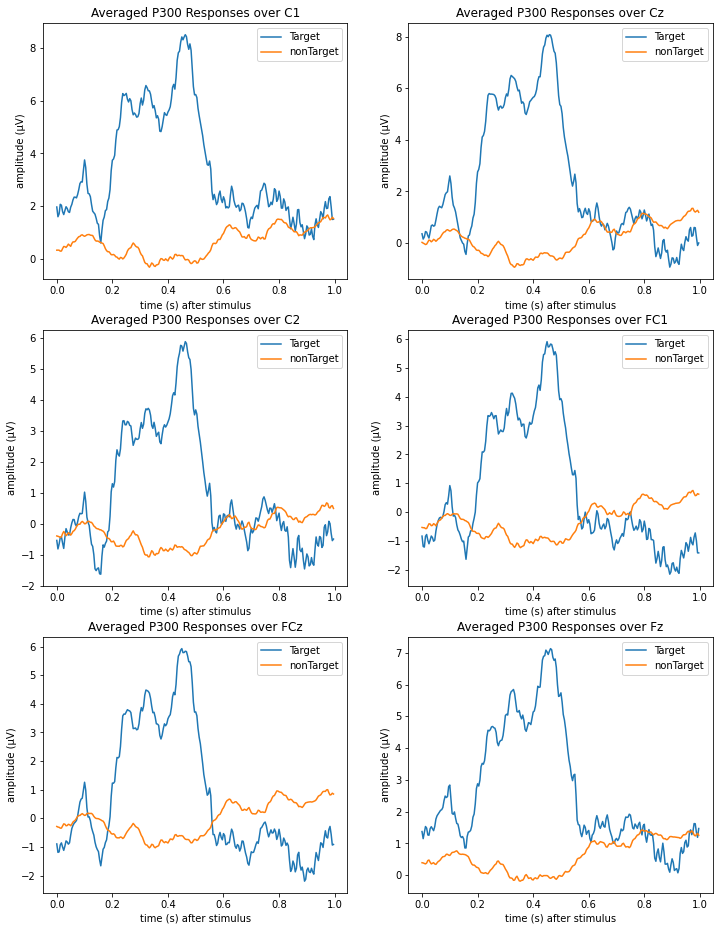

In [64]:
zone_label = { 9: 'C1', 10:'Cz', 11:'C2', 2:'FC1', 3:'FCz', 33:'Fz' }

plt.figure(figsize=(12,16))
for pos, channel in enumerate([9,10,11,2,3,33],1):
    plt.subplot(3,2,pos)
    plt.plot(np.array(range(240)) / 240, Tavg[:,channel], label='Target')
    plt.plot(np.array(range(240)) / 240, NTavg[:,channel], label='nonTarget')
    plt.title(f'Averaged P300 Responses over {zone_label[channel]}')
    plt.legend()
    plt.xlabel('time (s) after stimulus')
    plt.ylabel('amplitude (µV)')

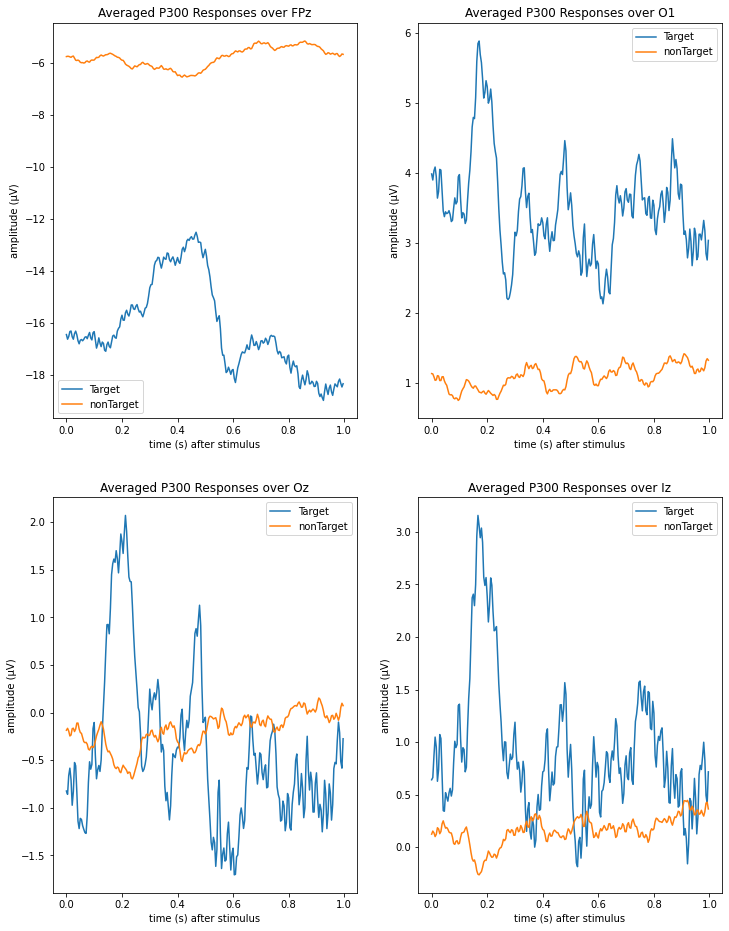

In [65]:
zone_label = { 22: 'FPz', 60:'O1', 61:'Oz', 63:'Iz'}

plt.figure(figsize=(12,16))
for pos, channel in enumerate([22,60,61,63],1):
    plt.subplot(2,2,pos)
    plt.plot(np.array(range(240)) / 240, Tavg[:,channel], label='Target')
    plt.plot(np.array(range(240)) / 240, NTavg[:,channel], label='nonTarget')
    plt.title(f'Averaged P300 Responses over {zone_label[channel]}')
    plt.legend()
    plt.xlabel('time (s) after stimulus')
    plt.ylabel('amplitude (µV)')

In [66]:
del responses, target, nonTarget, avgresp, Tavg, NTavg, rowcolcnt, zone_label, label, m, rowcol

# Preprocessing

## Last Blank Removal

In [67]:
class LastBlankRemoval(BaseEstimator, TransformerMixin):
    def __init__(self, blank_samples=234):
        self.blank_samples = blank_samples

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if len(X.shape) != 3 and len(X.shape) != 2:
            ValueError('X must be 3 or 2 dimensional: ' +
                       '(n_instances,n_samples_per_channel,n_channel) ' +
                       'or (n_instances,n_samples)')

        if (len(X.shape) == 3):
            return self._remove_last_blank_multi_channel(X)
        else:
            return self._remove_last_blank_single_channel(X)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

    def _remove_last_blank_single_channel(self, signals):
        return signals[:, 0:signals.shape[1] - self.blank_samples]

    def _remove_last_blank_multi_channel(self, X):
        return X[:, 0:X.shape[1] - self.blank_samples, :]

Text(0.5, 0, 'samples')

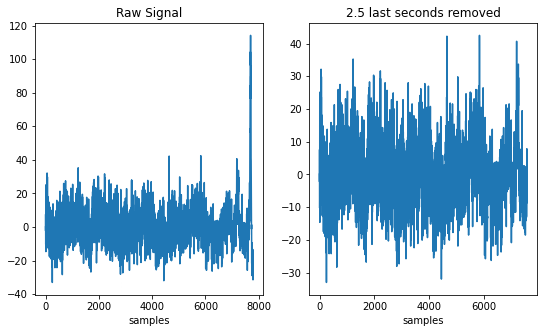

In [68]:
lbr = LastBlankRemoval(n_last_blank)


first_channel = train_data_a['signal'][:,:,0] # Frist channel signal
trans_first_channel = lbr.fit_transform(first_channel)

plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.plot(first_channel[0,:])  # first char epoch
plt.title('Raw Signal')
plt.xlabel('samples')
plt.subplot(1,2,2)
plt.plot(trans_first_channel[0,:]) #  first transformed char epoch
plt.title('2.5 last seconds removed')
plt.xlabel('samples')

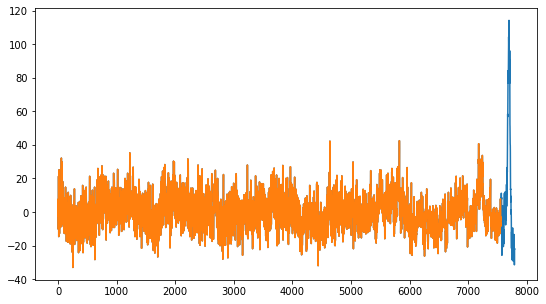

In [69]:
plt.close()
plt.figure(figsize=(9,5))
plt.plot(first_channel[0,:])
plt.plot(trans_first_channel[0,:])

In [70]:
plt.close()
del lbr, first_channel, trans_first_channel

## Power-line noise removal

In [71]:
class NotchFiltering(BaseEstimator, TransformerMixin):
    def __init__(self, freq=50., q=50.):
        self.f = freq
        self.q = q

    def fit(self, X=None, y=None):
        return self

    def transform(self, X, y=None):
        b, a = signal.iirnotch(self.f, self.q, fs)
        
        result = np.zeros(X.shape)
        if len(X.shape) == 2:
            for i in range(X.shape[0]):
                result[i,:] = signal.filtfilt(b, a, X[i, :])
        elif len(X.shape) == 3:
            for i in range(X.shape[0]):
                for j in range(X.shape[2]):
                    result[i,:,j] = signal.filtfilt(b, a, X[i, : ,j])
    
        return result

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

Text(0.5, 0, 'samples')

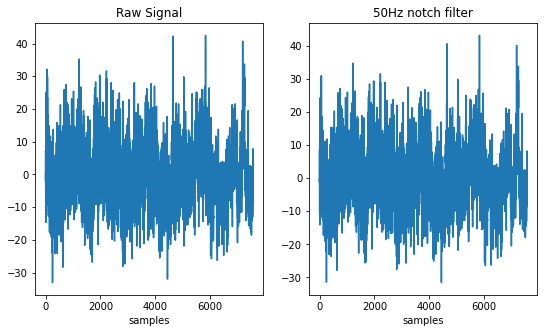

In [72]:
lbr = LastBlankRemoval()

notch = NotchFiltering()

first_channel = lbr.fit_transform(train_data_a['signal'][:,:,0]) # Frist channel signal
trans_first_channel = notch.fit_transform(first_channel)

plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.plot(first_channel[0,:])  # first char epoch
plt.title('Raw Signal')
plt.xlabel('samples')
plt.subplot(1,2,2)
plt.plot(trans_first_channel[0,:]) #  first transformed char epoch
plt.title('50Hz notch filter')
plt.xlabel('samples')

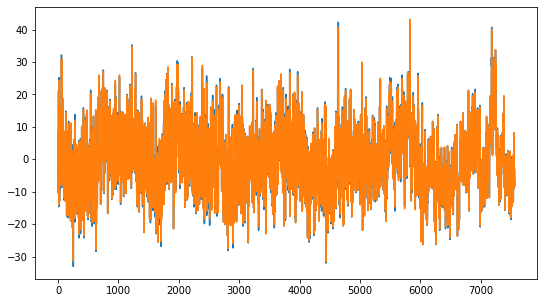

In [73]:
plt.close()
plt.figure(figsize=(9,5))
plt.plot(first_channel[0,:])
plt.plot(trans_first_channel[0,:])

In [74]:
plt.close()
del lbr, notch, first_channel, trans_first_channel

## Low pass

In [75]:
class LowPassFiltering(BaseEstimator, TransformerMixin):
    def __init__(self, f_high=20, order=8):
        self.high = f_high / (0.5 * fs)
        self.order = order

    def fit(self, X=None, y=None):
        return self

    def transform(self, X, y=None):
        b, a = signal.butter(self.order, self.high, btype='low')
        result = np.zeros(X.shape)
        if len(X.shape) == 2:
            for i in range(X.shape[0]):
                result[i,:] = signal.lfilter(b,a,X[i,:])
        elif len(X.shape) == 3:
            for i in range(X.shape[0]):
                for j in range(X.shape[2]):
                    result[i,:,j] = signal.lfilter(b,a,X[i,:,j])
        
        return result

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

Text(0.5, 0, 'samples')

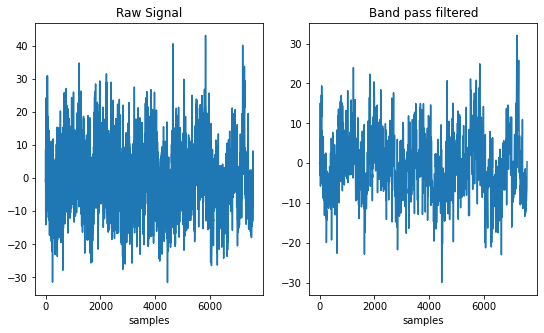

In [76]:
lbr = LastBlankRemoval()
notch = NotchFiltering()
bp = LowPassFiltering()


first_channel = notch.fit_transform(lbr.fit_transform(train_data_a['signal'][:,:,0]))
trans_first_channel = bp.fit_transform(first_channel)

plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.plot(first_channel[0,:])  # first char epoch
plt.title('Raw Signal')
plt.xlabel('samples')
plt.subplot(1,2,2)
plt.plot(trans_first_channel[0,:]) #  first transformed char epoch
plt.title('Band pass filtered')
plt.xlabel('samples')

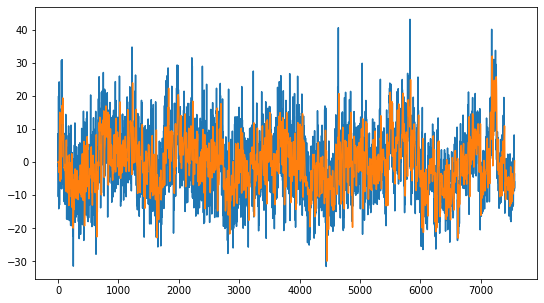

In [77]:
plt.close()
plt.figure(figsize=(9,5))
plt.plot(first_channel[0,:])
plt.plot(trans_first_channel[0,:])

In [78]:
plt.close()
del bp, first_channel, trans_first_channel

# Feature Selection & Feature Engineering

## P300 Activation Zone PCA

In [79]:
class P300ZoneExtraction(BaseEstimator,TransformerMixin):

    def fit(self, X, y = None):
        self.pca = PCA(n_components = 1, random_state = 16)
        return self

    def transform(self, X, y = None):
        if len(X.shape) != 3:
            ValueError("X shape must be 3 dimensional")
      

        result = np.zeros((X.shape[0],X.shape[1]))

        selected_channels = np.zeros((X.shape[0],X.shape[1],6))
        selected_channels[:,:,0] = X[:,:,9] # C1
        selected_channels[:,:,1] = X[:,:,10] # Cz
        selected_channels[:,:,2] = X[:,:,11] # C2
        selected_channels[:,:,3] = X[:,:,2] # FC1
        selected_channels[:,:,4] = X[:,:,3] # FCZ
        selected_channels[:,:,5] = X[:,:,33] # Fz

        for i in range(X.shape[0]): # For each instance
            result[i, :] = self.pca.fit_transform(selected_channels[i,:,:]).reshape([X.shape[1]])
 
        return result

## Brain zones extraction

In [80]:
class BrainZonesSignalExtraction(BaseEstimator,TransformerMixin):


  def fit(self, X, y = None):
    self.pca = PCA(n_components=1,random_state=16)
    return self

  def transform(self, X, y = None):
    if len(X.shape) != 3:
      ValueError('X Shape must be 3 dimensional')
    
    result = np.zeros((X.shape[0],X.shape[1],7))

    motor_cortex = X[:,:,0:7] # 1-7 Motor Cortex
    central_sulcus = X[:,:,7:14] # 8-14 Central Sulcus
    sensorimotor_cortex = X[:,:,14:21] # 15-21 Sensorimotor Cortex
    frontal_lobe = X[:,:,21:38] # 22-38 Frontal Lobe
    temporal_lobe = X[:,:,38:46] # 39-46 Tempral Lobe
    parietal_lobe = X[:,:,46:60] # 47-60 Parietal Lobe
    occipital_lobe = X[:,:,60:64] # 61-64 Occipital Lobe

    result[:,:,0] = self._extract_single_signal(motor_cortex)
    result[:,:,1] = self._extract_single_signal(central_sulcus)
    result[:,:,2] = self._extract_single_signal(sensorimotor_cortex)
    result[:,:,3] = self._extract_single_signal(frontal_lobe)
    result[:,:,4] = self._extract_single_signal(temporal_lobe)
    result[:,:,5] = self._extract_single_signal(parietal_lobe)
    result[:,:,6] = self._extract_single_signal(occipital_lobe)

    return result

  def fit_transform(self, X, y = None):
    self.fit(X,y)
    return self.transform(X,y)

  def _extract_single_signal(self,zone):
    result = np.zeros((zone.shape[0],zone.shape[1]))

    for i in range(zone.shape[0]):
      result[i,:] = self.pca.fit_transform(zone[i,:,:]).flatten()

    return result

## Statistical features

- Standard Deviation
- Median Absolute Deviation
- L1-norm
- L2-norm
- Inf-norm
- Spectral Entropy
- Fractal Dimension Analysis

In [81]:
class StatisticalFeatures(BaseEstimator,TransformerMixin):
  """
    Statistical features from single signal or multichannel signal
  """

  def __init__(self):
    self.n_stats = 7

  def fit(self, X, y = None):
    return self

  
  def transform(self, X, y = None):
    """
    Parameters
      ----------
      X : Array
        Data to transform, must be 3 or 2 dimentional: 
            (n_instances, n_samples_per_channel, n_channel)
            (n_instances, n_samples)

    Returns
    ---------
    (n_instances, n_samples_per_channel, n_channel) -> (n_instances, n_channel*7)
    (n_instances, n_samples) -> (n_instances, 7)
    """

    if(len(X.shape) != 3 and len(X.shape) != 2):
          ValueError('X must be 3 or 2 dimensional: '
                    + '(n_instances,n_samples_per_channel,n_channel) '
                    + 'or (n_instances,n_samples)')

    if(len(X.shape) == 3):
      return self._get_statistical_features_multi_channel(X).reshape([X.shape[0],-1])
    else:
      return self._get_statistical_features_single_channel(X)

  def fit_transform(self, X, y = None):
    """
    Parameters
    ----------
      X : Array
        Data to transform, must be 3 or 2 dimentional: 
            (n_instances, n_samples_per_channel, n_channel)
            (n_instances, n_samples)

    Returns
    ---------
    (n_instances, n_samples_per_channel, n_channel) -> (n_instances,7, n_channel)
    (n_instances, n_samples) -> (n_instances, 7)

    """

    self.fit(X)
    return self.transform(X)



  def _get_statistical_features_single_channel(self, signals):
    n_instances = signals.shape[0]
    std = np.std(signals,axis=1)
    medAd = stats.median_absolute_deviation(signals,axis=1)
    l1_norm = np.linalg.norm(signals,ord=1,axis=1)
    l2_norm = np.linalg.norm(signals,ord=2,axis=1) 
    inf_norm = np.linalg.norm(signals,ord=np.inf,axis=1)
    spectral_entropy = np.zeros((signals.shape[0]))
    fda = np.zeros((signals.shape[0]))

    for i in range(n_instances):
      comp = complexity(signals[i,:],
                        shannon=False,
                        sampen=False,
                        multiscale=False,
                        svd=False,
                        correlation=False,
                        petrosian=False,
                        fisher=False,
                        hurst=False,
                        dfa=False,
                        lyap_r=False,
                        lyap_e=False)
      spectral_entropy[i] = comp['Entropy_Spectral']
      fda[i] = comp['Fractal_Dimension_Higushi']
    return np.hstack((std.reshape([-1,1]),
                      medAd.reshape([-1,1]),
                      l1_norm.reshape([-1,1]),
                      l2_norm.reshape([-1,1]),
                      inf_norm.reshape([-1,1]),
                      spectral_entropy.reshape([-1,1]),
                      fda.reshape([-1,1])))
    
  def _get_statistical_features_multi_channel(self,X):
    result = np.zeros((X.shape[0],self.n_stats,X.shape[2]))

    for j in range(X.shape[2]):
      result[:,:,j] = self._get_statistical_features_single_channel(X[:,:,j])

    return result  
    
  

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:62: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/neurokit/signal/complexity.py:502: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)


  Standard Deviation    Median Absolute Deviation    L1-norm    L2-norm    Max-norm    Spectral entropy    Fractal Dimension Analysis
--------------------  ---------------------------  ---------  ---------  ----------  ------------------  ----------------------------
              11.495                      9.20588    62738.8    1014.84     114.176             8.84498                       1.77192


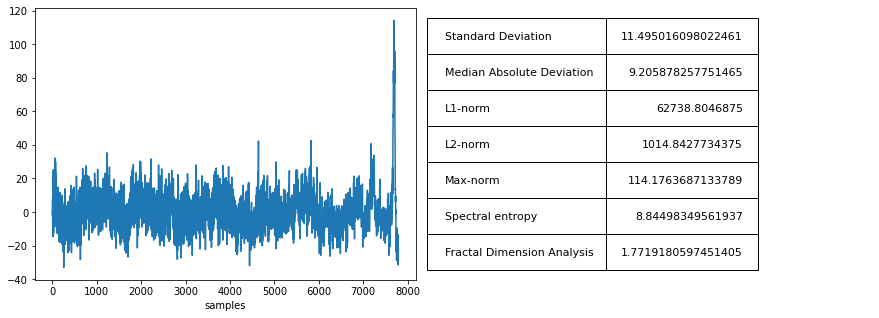

In [82]:
std_F = StatisticalFeatures()

stats_train_channel_0 = std_F.fit_transform(train_data_a['signal'][:,:,0])
header = ["Standard Deviation","Median Absolute Deviation","L1-norm","L2-norm","Max-norm","Spectral entropy","Fractal Dimension Analysis"]

print(tabulate(stats_train_channel_0[0].reshape([1,-1]),headers=header))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_data_a['signal'][0,:,0])
plt.xlabel('samples')
plt.subplot(1,2,2)
table = plt.table(cellText=stats_train_channel_0[0].reshape([-1,1]),loc='center',rowLabels=header,colWidths=[.5]*7)
plt.axis("off")
table.set_fontsize(34)
table.scale(.8, 3)

In [83]:
del std_F, stats_train_channel_0, header,table

## Decimator

In [84]:
class Decimator(BaseEstimator,TransformerMixin):
    
    def __init__(self, decimation_factor = 12):
        self.decimation_factor = decimation_factor
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        if len(X.shape) == 2:
            return X[:,::self.decimation_factor]
        elif len(X.shape) == 3:
            return X[:,::self.decimation_factor,:].reshape([X.shape[0],-1])

## Intensification Window Extractor

In [85]:
class IntensificationWindowExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, flashing_mask, n_windows = 12 * 15, n_samples_per_intensification = 160):
        self.n_windows = n_windows
        self.flashing_mask = flashing_mask
        self.n_samples_per_intensification = n_samples_per_intensification
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        skip = False
        count = 0
        
        if len(X.shape) == 3:
            result = np.zeros((X.shape[0], self.n_windows, self.n_samples_per_intensification , X.shape[2])) 
            
            for sample in range(self.flashing_mask.shape[1]):
                if not skip and self.flashing_mask[0,sample] == 1:
                    skip = True
                    try:
                        result[:, count, :, :] = X[:,sample: sample+ self.n_samples_per_intensification, :]
                        count +=1
                    except:
                        pass
                elif skip and self.flashing_mask[0,sample] == 0:
                    skip = False
                    
            result = np.reshape(result, (result.shape[0]*result.shape[1],result.shape[2], result.shape[3]))
            
            return result
        elif len(X.shape) == 2:
            result = np.zeros((X.shape[0], self.n_windows, self.n_samples_per_intensification))
            
            for sample in range(self.flashing_mask.shape[1]):
                if not skip and self.flashing_mask[0,sample] == 1:
                    skip = True
                    try:
                        result[:, count,:] = X[:, sample:sample+ self.n_samples_per_intensification]
                        count += self.n_samples_per_intensification
                    except:
                        pass
                elif skip and self.flashing_mask[0,sample] == 0:
                    skip = False
                    
            return result
            
            
    def transform_stimulus_code(self, X): 
        result = np.zeros((X.shape[0], self.n_windows))
        skip = False
        count = 0

        for sample in range(self.flashing_mask.shape[1]):
            if not skip and self.flashing_mask[0,sample] == 1:
                skip = True
                try:
                    result[:, count] = X[:, sample]
                    count +=1
                except:
                    pass
            elif skip and self.flashing_mask[0,sample] == 0:
                skip = False

        return result

# Character Classification

In [86]:
clfs = [    LinearDiscriminantAnalysis(),
            svm.SVC(C=0.01),
            svm.SVC(C=0.05),
            svm.SVC(C=0.1),
            svm.SVC(C=0.5),
            svm.SVC(C=1),
            KNeighborsClassifier(n_neighbors=10),
        ]

In [87]:
def reset_clfs():
    clfs = [    LinearDiscriminantAnalysis(),
            svm.SVC(C=0.01),
            svm.SVC(C=0.05),
            svm.SVC(C=0.1),
            svm.SVC(C=0.5),
            svm.SVC(C=1),
            KNeighborsClassifier(n_neighbors=10),
        ] 

def classifiers_stats(classifiers, train_x, train_y, test_x, test_y):
    result = {}
    result['prediction'] = []
    result['accuracy_score'] = []
    result['class_report'] = []
    result['confusion_matrix'] = []

    for clf in tqdm(classifiers):
        clf.fit(train_x, train_y)
        clf_prediction = clf.predict(test_x)
        result['prediction'].append(clf_prediction)
        result['accuracy_score'].append(accuracy_score(test_y, clf_prediction))
        result['class_report'].append(
            classification_report(test_y, clf_prediction, zero_division=0))
        result['confusion_matrix'].append(
            confusion_matrix(test_y, clf_prediction))

    return result

## Filtered Raw Classification

__WARNING__: this may consume too much RAM, be cautious!

In [88]:
filtered_pipeline = Pipeline([
    ("lbr", LastBlankRemoval()),
    ("powerline", NotchFiltering()),
    ("lowpass", LowPassFiltering())
])

### Subject A

In [89]:
x_train = filtered_pipeline.fit_transform(train_data_a['signal'])
x_train = x_train.reshape([x_train.shape[0],-1]) 

y_train = train_data_a['target']

x_test = filtered_pipeline.fit_transform(test_data_a['signal'])
x_test = x_test.reshape([x_test.shape[0],-1]) 

y_test = test_data_a['target']

result = classifiers_stats(clfs,x_train,y_train,x_test,y_test)

100%|██████████| 7/7 [01:48<00:00, 15.45s/it]


In [90]:
result['accuracy_score']

[0.1, 0.11, 0.11, 0.11, 0.11, 0.11, 0.07]

In [91]:
result['prediction']

[array(['O', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'D', 'O', 'O', 'O', 'E', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'E', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'T',
        'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'R', 'O',
        'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O'], dtype='<U1'),
 array(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [92]:
reset_clfs()
del x_train, y_train, x_test, y_test

### Subject B

In [93]:
x_train = filtered_pipeline.fit_transform(train_data_b['signal'])
x_train = x_train.reshape([x_train.shape[0],-1]) 

y_train = train_data_b['target']

x_test = filtered_pipeline.fit_transform(test_data_b['signal'])
x_test = x_test.reshape([x_test.shape[0],-1]) 

y_test = test_data_b['target']

result = classifiers_stats(clfs,x_train,y_train,x_test,y_test)

100%|██████████| 7/7 [01:50<00:00, 15.72s/it]


In [94]:
result['accuracy_score']

[0.07, 0.11, 0.11, 0.11, 0.11, 0.11, 0.03]

In [95]:
reset_clfs()
del x_train, y_train, x_test, y_test, filtered_pipeline

## Filtered P300 Activation Zone Signal

In [96]:
filtered_pipeline = Pipeline([
    ("lbr", LastBlankRemoval()),
    ("powerline", NotchFiltering()),
    ("lowpass", LowPassFiltering()),
    ("p300", P300ZoneExtraction())
])

### Subject A

In [97]:
x_train = filtered_pipeline.fit_transform(train_data_a['signal'])
x_train = x_train.reshape([x_train.shape[0],-1]) 

y_train = train_data_a['target']

x_test = filtered_pipeline.fit_transform(test_data_a['signal'])
x_test = x_test.reshape([x_test.shape[0],-1]) 

y_test = test_data_a['target']

result = classifiers_stats(clfs,x_train,y_train,x_test,y_test)

100%|██████████| 7/7 [00:01<00:00,  4.14it/s]


In [98]:
result['accuracy_score']

[0.08, 0.11, 0.11, 0.11, 0.11, 0.11, 0.05]

In [99]:
reset_clfs()
del x_train, y_train, x_test, y_test

### Subject B

In [100]:
x_train = filtered_pipeline.fit_transform(train_data_b['signal'])
x_train = x_train.reshape([x_train.shape[0],-1]) 

y_train = train_data_b['target']

x_test = filtered_pipeline.fit_transform(test_data_b['signal'])
x_test = x_test.reshape([x_test.shape[0],-1]) 

y_test = test_data_b['target']

result = classifiers_stats(clfs,x_train,y_train,x_test,y_test)

100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


In [101]:
result['accuracy_score']

[0.07, 0.11, 0.11, 0.11, 0.11, 0.11, 0.04]

In [102]:
reset_clfs()
del x_train, y_train, x_test, y_test, filtered_pipeline

## Filtered P300 activation Zone Statistical Features

In [103]:
filtered_pipeline = Pipeline([
    ("lbr", LastBlankRemoval()),
    ("powerline", NotchFiltering()),
    ("lowpass", LowPassFiltering()),
    ("p300", P300ZoneExtraction()),
    ("st", StatisticalFeatures())
])

### Subject A

In [104]:
x_train = filtered_pipeline.fit_transform(train_data_a['signal'])
y_train = train_data_a['target']

x_test = filtered_pipeline.fit_transform(test_data_a['signal'])
y_test = test_data_a['target']

result = classifiers_stats(clfs,x_train,y_train,x_test,y_test)

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:62: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/neurokit/signal/complexity.py:502: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)
/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimes

In [105]:
result['accuracy_score']

[0.1, 0.11, 0.11, 0.11, 0.11, 0.11, 0.05]

In [106]:
reset_clfs()
del x_train, y_train, x_test, y_test

### Subject B

In [107]:
x_train = filtered_pipeline.fit_transform(train_data_b['signal'])
y_train = train_data_b['target']

x_test = filtered_pipeline.fit_transform(test_data_b['signal'])
y_test = test_data_b['target']

result = classifiers_stats(clfs,x_train,y_train,x_test,y_test)

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:62: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/neurokit/signal/complexity.py:502: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)
/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimes

In [108]:
result['accuracy_score']

[0.06, 0.11, 0.11, 0.11, 0.11, 0.11, 0.05]

In [109]:
reset_clfs()
del x_train, y_train, x_test, y_test, filtered_pipeline

## Brain Zones Statistical Features

In [110]:
filtered_pipeline = Pipeline([
    ("lbr", LastBlankRemoval()),
    ("powerline", NotchFiltering()),
    ("lowpass", LowPassFiltering()),
    ("brain_zone", BrainZonesSignalExtraction()),
    ("st", StatisticalFeatures())
])

### Subject A

In [111]:
x_train = filtered_pipeline.fit_transform(train_data_a['signal'])
y_train = train_data_a['target']

x_test = filtered_pipeline.fit_transform(test_data_a['signal'])
y_test = test_data_a['target']

result = classifiers_stats(clfs,x_train,y_train,x_test,y_test)

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:62: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/neurokit/signal/complexity.py:502: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)
/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimes

In [112]:
result['accuracy_score']

[0.05, 0.11, 0.11, 0.11, 0.11, 0.11, 0.06]

In [113]:
reset_clfs()
del x_train, y_train, x_test, y_test

### Subject B

In [114]:
x_train = filtered_pipeline.fit_transform(train_data_b['signal'])
y_train = train_data_b['target']

x_test = filtered_pipeline.fit_transform(test_data_b['signal'])
y_test = test_data_b['target']

result = classifiers_stats(clfs,x_train,y_train,x_test,y_test)

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:62: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/neurokit/signal/complexity.py:502: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)
/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimes

In [115]:
result['accuracy_score']

[0.02, 0.11, 0.11, 0.11, 0.11, 0.11, 0.05]

In [116]:
reset_clfs()
del x_train, y_train, x_test, y_test, filtered_pipeline

# Binary Classification

In [38]:
clfs = [    LinearDiscriminantAnalysis(),
            svm.SVC(C=0.01),
            KNeighborsClassifier(n_neighbors=10),
        ]

In [39]:
def bin_pred_to_char(n_target,bin_pred,stimulus_code_test):
    
    pr_by_window = []
    
    for c in range(n_target):
      row_cols = {}

      for w in range(180):
        if not stimulus_code_test[c,w] in row_cols:
          row_cols[stimulus_code_test[c,w]] = bin_pred[c * 180 + w]
        else:
          row_cols[stimulus_code_test[c,w]] += bin_pred[c * 180 + w]

      maxRow = -np.Inf
      maxCol = 0
      rowIndex = colIndex = 0

      for k in row_cols.keys():
        if k < 7 and row_cols[k] > maxCol:
          maxCol = row_cols[k]
          colIndex = k
        elif k >= 7 and row_cols[k] > maxRow:
          maxRow = row_cols[k]
          rowIndex = k

      pr_by_window.append(query_char(int(rowIndex), int(colIndex)))
    
    return pr_by_window

## Filtered Raw Binary Classification
__Warning__: This may take a long time to execute, be cautious!

### Subject A

In [40]:
intens = IntensificationWindowExtractor(train_data_a['flashing'])
decim = Decimator()

pipe_x = Pipeline([
    ("lbr", LastBlankRemoval()),
    ("powerline", NotchFiltering()),
    ("lowpass", LowPassFiltering()),
    ("intensification", intens),
    ("decimator", decim),
])

pipe_y = Pipeline([
    ("intensification", intens)
]) 

x_train = pipe_x.fit_transform(train_data_a['signal'])
y_train = intens.transform_stimulus_code(train_data_a['stimulus_code'])
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))
y_train[y_train == 0]  = -1

x_test = pipe_x.fit_transform(test_data_a['signal'])
y_test = intens.transform_stimulus_code(test_data_a['stimulus_code'])
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1]))
y_test[y_test == 0]  = -1

stimulus_code_test = intens.transform_stimulus_code(test_data_a['stimulus_code'])

In [41]:
for clf in tqdm(clfs):
    clf.fit(x_train,y_train)
    pred = clf.predict(x_test)
    pred_char = bin_pred_to_char(test_data_a['target'].shape[0],pred,stimulus_code_test)
    
    print(f"Accuracy: {accuracy_score(test_data_a['target'],pred_char)}")

 33%|███▎      | 1/3 [00:03<00:06,  3.31s/it]

Accuracy: 0.02


 67%|██████▋   | 2/3 [12:52<03:53, 233.10s/it]

Accuracy: 0.01


100%|██████████| 3/3 [19:04<00:00, 381.59s/it]

Accuracy: 0.02


### Subject B

In [42]:
intens = IntensificationWindowExtractor(train_data_b['flashing'])
decim = Decimator()

pipe_x = Pipeline([
    ("lbr", LastBlankRemoval()),
    ("powerline", NotchFiltering()),
    ("lowpass", LowPassFiltering()),
    ("intensification", intens),
    ("decimator", decim),
])

pipe_y = Pipeline([
    ("intensification", intens)
]) 

x_train = pipe_x.fit_transform(train_data_b['signal'])
x_train = x_train
y_train = intens.transform_stimulus_code(train_data_b['stimulus_code'])
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))
y_train[y_train == 0]  = -1

x_test = pipe_x.fit_transform(test_data_b['signal'])
y_test = intens.transform_stimulus_code(test_data_b['stimulus_code'])
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1]))
y_test[y_test == 0]  = -1

stimulus_code_test = intens.transform_stimulus_code(test_data_b['stimulus_code'])

for clf in tqdm(clfs):
    clf.fit(x_train,y_train)
    pred = clf.predict(x_test)
    pred_char = bin_pred_to_char(test_data_b['target'].shape[0],pred,stimulus_code_test)

    print(f"Accuracy: {accuracy_score(test_data_b['target'],pred_char)}")
    
    

 33%|███▎      | 1/3 [00:03<00:07,  3.96s/it]

Accuracy: 0.01


 67%|██████▋   | 2/3 [12:57<03:54, 234.70s/it]

Accuracy: 0.03


100%|██████████| 3/3 [19:08<00:00, 382.69s/it]

Accuracy: 0.0


## Filtered P300 Activation Zone Signal Binary Classification

### Subject A

In [43]:
intens = IntensificationWindowExtractor(train_data_a['flashing'])

pipe_x = Pipeline([
    ("lbr", LastBlankRemoval()),
    ("powerline", NotchFiltering()),
    ("lowpass", LowPassFiltering()),
    ("p300", P300ZoneExtraction()),
    ("intensification", intens)
])

pipe_y = Pipeline([
    ("intensification", intens)
]) 

x_train = pipe_x.fit_transform(train_data_a['signal']).reshape((-1,160))
y_train = intens.transform_stimulus_code(train_data_a['stimulus_code'])
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))
y_train[y_train == 0]  = -1


x_test = pipe_x.fit_transform(test_data_a['signal']).reshape((-1,160))
y_test = intens.transform_stimulus_code(test_data_a['stimulus_code'])
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1]))
y_test[y_test == 0]  = -1

In [44]:
for clf in tqdm(clfs):
    clf.fit(x_train,y_train)
    pred = clf.predict(x_test)
    pred_char = bin_pred_to_char(test_data_a['target'].shape[0],pred,stimulus_code_test)

    print(f"Accuracy: {accuracy_score(test_data_a['target'],pred_char)}")

 33%|███▎      | 1/3 [00:00<00:00,  2.09it/s]

Accuracy: 0.03


 67%|██████▋   | 2/3 [02:04<00:37, 37.52s/it]

Accuracy: 0.01


100%|██████████| 3/3 [03:00<00:00, 60.07s/it]

Accuracy: 0.01


### Subject B

In [45]:
intens = IntensificationWindowExtractor(train_data_b['flashing'])

pipe_x = Pipeline([
    ("lbr", LastBlankRemoval()),
    ("powerline", NotchFiltering()),
    ("lowpass", LowPassFiltering()),
    ("p300", P300ZoneExtraction()),
    ("intensification", intens)
])

pipe_y = Pipeline([
    ("intensification", intens)
]) 

x_train = pipe_x.fit_transform(train_data_b['signal']).reshape((-1,160))
y_train = intens.transform_stimulus_code(train_data_b['stimulus_code'])
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))
y_train[y_train == 0]  = -1


x_test = pipe_x.fit_transform(test_data_b['signal']).reshape((-1,160))
y_test = intens.transform_stimulus_code(test_data_b['stimulus_code'])
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1]))
y_test[y_test == 0]  = -1

In [46]:
for clf in tqdm(clfs):
    clf.fit(x_train,y_train)
    pred = clf.predict(x_test)
    pred_char = bin_pred_to_char(test_data_b['target'].shape[0],pred,stimulus_code_test)

    print(f"Accuracy: {accuracy_score(test_data_b['target'],pred_char)}")

 33%|███▎      | 1/3 [00:00<00:00,  2.26it/s]

Accuracy: 0.03


 67%|██████▋   | 2/3 [02:18<00:41, 41.66s/it]

Accuracy: 0.05


100%|██████████| 3/3 [03:22<00:00, 67.59s/it]

Accuracy: 0.05


# Wyrm Approach
Venthur, B., Dähne, S., Höhne, J., Heller, H., & Blankertz, B. (2015). Wyrm: A Brain-Computer Interface Toolbox in Python. Neuroinformatics, 13(4), 471–486. https://doi.org/10.1007/s12021-015-9271-8

We tried to use the python library hosted on [github](https://github.com/bbci/wyrm), but it is only compatible until python version 3.4. So we tried to implement their approach.

## Prepare the data

In [117]:
lbr = LastBlankRemoval()

x_train = lbr.fit_transform(train_data_a['signal'])
x_train = x_train.reshape(-1, x_train.shape[2])
flashing = lbr.fit_transform(train_data_a['flashing'])
flashing = flashing.reshape(-1)
stimulus_code = lbr.fit_transform(train_data_a['stimulus_code'])
stimulus_code = stimulus_code.reshape(-1)
stimulus_type = lbr.fit_transform(train_data_a['stimulus_type'])
stimulus_type = stimulus_type.reshape(-1)

x_test = lbr.fit_transform(test_data_a['signal'])
s = x_test.shape
x_test = x_test.reshape(-1, x_test.shape[2])
flashing_test = lbr.fit_transform(test_data_a['flashing'])
flashing_test = flashing_test.reshape(-1)
stimulus_code_test = lbr.fit_transform(test_data_a['stimulus_code'])
stimulus_code_test = stimulus_code_test.reshape(-1)

mask = flashing == 1
mask_test = flashing_test == 1

In [118]:
stimulus_type_test = np.zeros(stimulus_code_test.shape)

for i in range(s[0]):
    targetChar = test_data_a['target'][i]
    row, column = query_row_column(targetChar)
    stimulus_type_test[i,stimulus_code_test[i] == row] = 1
    stimulus_type_test[i,stimulus_code_test[i] == column] = 1
    
stimulus_type_test = stimulus_type_test.reshape(-1)

## 30 Hz LowPass + 0.4 Hz HighPass

In [119]:
fs = 240 / 2

data = np.zeros(x_train.shape)
b, a = signal.butter(16, [30 / fs], btype='low')

for i in range(x_train.shape[0]):
    data[i,:] = signal.lfilter(b,a,x_train[i,:])

b, a = signal.butter(5, [.4 / fs], btype='high')
for i in range(data.shape[0]):
    data[i,:] = signal.lfilter(b,a,data[i,:])
    
data_test = np.zeros(x_test.shape)
b, a = signal.butter(16, [30 / fs], btype='low')

for i in range(x_test.shape[0]):
    data_test[i,:] = signal.lfilter(b,a,x_test[i,:])

b, a = signal.butter(5, [.4 / fs], btype='high')
for i in range(data_test.shape[0]):
    data_test[i,:] = signal.lfilter(b,a,data_test[i,:])

## Sumbsampling to 60 Hz

In [120]:
decimation_factor = int(240 / 60)

x_train_sub = x_train[::decimation_factor, :]
mask_sub = mask[::decimation_factor]
stimulus_code_sub = stimulus_code[::decimation_factor]
stimulus_type_sub = stimulus_type[::decimation_factor]

x_test_sub = x_test[::decimation_factor, :]
mask_test_sub = mask_test[::decimation_factor]
stimulus_code_test_sub = stimulus_code_test[::decimation_factor]
stimulus_type_test_sub = stimulus_type_test[::decimation_factor]

del x_train, mask, stimulus_code, stimulus_type, x_test, mask_test, stimulus_code_test, stimulus_type_test

## [0, 700) ms segmentation

In [121]:
window_size = int(60 * 0.7) # 700 ms to samples
x_train_seg = np.zeros((int(np.sum(mask_sub) * window_size), 64))
stimulus_code_seg = np.zeros((int(np.sum(mask_sub) * window_size)))
stimulus_type_seg = np.zeros((int(np.sum(mask_sub) * window_size)))

count = 0
for sample in range(x_train_sub.shape[0]):
    if mask_sub[sample]:
        try:
            x_train_seg[count:count + window_size, :] = x_train_sub[sample:sample + window_size, :]
            stimulus_code_seg[count:count + window_size] = stimulus_code_sub[sample:sample + window_size]
            stimulus_type_seg[count:count + window_size] = stimulus_type_sub[sample:sample + window_size]
            count += window_size
        except:
            pass # Discard last 168 elems

x_test_seg = np.zeros((int(np.sum(mask_test_sub) * window_size), 64))
stimulus_code_test_seg = np.zeros((int(np.sum(mask_test_sub) * window_size)))
stimulus_type_test_seg = np.zeros((int(np.sum(mask_test_sub) * window_size)))

count = 0
for sample in range(x_test_sub.shape[0]):
    if mask_test_sub[sample]:
        try:
            x_test_seg[count:count + window_size, :] = x_test_sub[sample:sample + window_size, :]
            stimulus_code_test_seg[count:count + window_size] = stimulus_code_test_sub[sample:sample + window_size]
            stimulus_type_test_seg[count:count + window_size] = stimulus_type_test_sub[sample:sample + window_size]
            count += window_size
        except:
            pass # Discard last 168 elems
        
x_train_seg = x_train_seg[:-966]
x_test_seg = x_test_seg[:-966]
stimulus_code_seg = stimulus_code_seg[:-966]
stimulus_type_seg = stimulus_type_seg[:-966]
stimulus_code_test_seg = stimulus_code_test_seg[:-966]
stimulus_type_test_seg = stimulus_type_test_seg[:-966]

del x_test_sub, x_train_sub, mask_sub, mask_test_sub, stimulus_code_sub, stimulus_type_sub, stimulus_code_test_sub, stimulus_type_test_sub

## LDA

In [122]:
ld = LinearDiscriminantAnalysis()
ld.fit(x_train_seg, stimulus_code_seg)

preds = ld.predict(x_test_seg)

In [123]:
accuracy_score(stimulus_type_test_seg, preds)

0.9999898567463882

The accuracy is very high, but it does not mean anything, because the prediction, as shown below, is always 0, meaning that no character can be predicted, as there is no row or column to perform majority voting.

In [124]:
np.sum(preds)

0.0